In [524]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import numpy as np
import seaborn as sns
import pathlib
import re
import yaml



import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

NOTE: Change `sim_idx` to make plots for different simulation specifications (see below).

First we set up some global plotting parameters

In [525]:
with open('plot_settings.yml', 'r') as file:
    config = yaml.safe_load(file)

for key, value in config['paper']['rcParams'].items():
    plt.rcParams[key] = value

legend_info = config['paper']['legend_info']
legend_labels = legend_info['legend_labels']
fig_dpi = config['paper']['fig_dpi']
palette = sns.color_palette(legend_info['sns_palette'], len(legend_info['mode_order']))

fig_width = 1.2
fig_height = 1.2

This cell sets the directory in which we can find our data, as well as the simulation type this notebook will plot.

In [526]:
# Change sim_idx to make plots for different simulation specifications.
# CHOICES: sim_idx = 0, 1, or 2
sim_idx = 1
sim_types = ["single_type_no_death", "single_type_w_death", "multitype_high_birth_fitness"]
yticks_arr = [[1,2,4,6],'default',[1,2,4,6]]

data_directory = pathlib.Path("data")
sim_type = sim_types[sim_idx]
yticks = yticks_arr[sim_idx]
fig_directory = pathlib.Path("fig")/sim_type
fig_directory.mkdir(parents=True, exist_ok=True)

We collect all the data that we will needto make timing plots for the simulation type into `all_trees_metrics_df`.

In [527]:
import re
from pathlib import Path

all_tree_metrics_df = pd.DataFrame()

for mode in ["full","FE"]:

    path_to_directory = data_directory/sim_type/mode  # This should be replaced with the actual path

    # Regular expression pattern to extract 'rho' and 'counter' from the filenames
    pattern = re.compile(rf"tree_metrics_{sim_type}_rho(\d+)_v(\d+)_df\.csv")

    # Iterate over all csv files in the directory
    for file_path in path_to_directory.glob(f"tree_metrics_{sim_type}_rho*_v*_df.csv"):

        # Use the regex pattern to search the filename string
        match = pattern.search(file_path.name)
        if match:
            # Extract 'rho' and 'counter' from the regex groups
            rho = int(match.group(1)) / 10  # Dividing by 10 because the filename contains 10*rho
            counter = int(match.group(2))
            
            # Read the csv file
            tree_metrics_df = pd.read_csv(file_path)[["seed","time","unpruned tree size","pruned tree size","pruned tree leaf count"]]
            tree_metrics_df["rho"] = rho
            tree_metrics_df["mode"] = mode

            all_tree_metrics_df = pd.concat([all_tree_metrics_df, tree_metrics_df])


    all_tree_metrics_df.head()


We make a scatter plot in which each point is a simulated tree, on the x-axis is the total number of nodes (which includes death and mutation events) in the "unpruned tree", and the y-axis is the time it took to simulate this tree. 

The time a simulation takes is a nearly deterministic function of the number of events in the tree. Because, in these simulation, the full simulation can draw has events arriving according to constant rate Poisson processes and the forward equivalent simulation has events arriving according to variable rate Poisson process, there is some computational overhead in the forward equivalent simulation when we compare at a fixed value of the unpruned tree size. Note, however, that in the forward equivalent simulations, the unpruned trees tend to be much smaller, because they are exactly the same size as the pruned trees.

In [528]:
%%capture

# List of x-axis column names for the plots
# x_columns = ["rho", "unpruned tree size", "pruned tree size", "pruned tree leaf count"]
x_columns = ["unpruned tree size"]

# Loop over each x-axis column name and create a plot
for x_col in x_columns:
    plt.figure(figsize=(fig_width, fig_height), dpi = fig_dpi)
    ax = sns.scatterplot(data=all_tree_metrics_df, x=x_col, y="time", hue="mode", s = 10, palette=palette, hue_order=legend_info['mode_order'])

    handles = ax.get_legend().legend_handles
    labels = [text.get_text() for text in ax.get_legend().get_texts()]
    ax.get_legend().remove()  # Remove the legend from the current plot, but keep the plot itself

    # Set the y-axis to use ScalarFormatter
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)

    # Adjust the position of the offset text (scientific notation part)
    # ax.yaxis.get_offset_text().set_position((0,1)) # Uncomment this to adjust position
    ax.yaxis.get_offset_text().set_visible(True)

    plt.savefig(fig_directory/f"{sim_type}_{x_col.replace(' ','_')}_vs_time.pdf", bbox_inches="tight", dpi = fig_dpi)


Because the forward equivalent simulation does not need to track all the events that occur in the full, unobserved tree, it can be dramatically faster than the full simulation, with speed-ups most dramatic when a smaller fraction fo the full tree is observed.

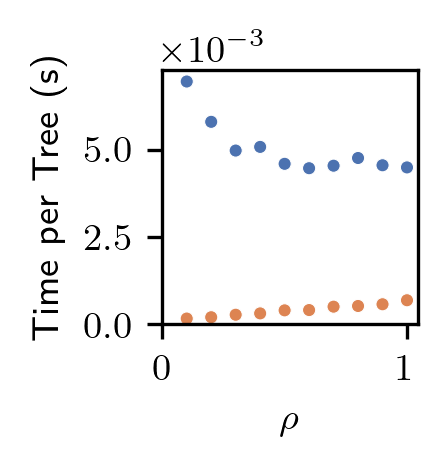

In [529]:
# %%capture

# Calculate the sum of 'time' for each value of 'rho'
time_sum = all_tree_metrics_df.groupby(['rho','mode'])['time'].sum().reset_index()

# Calculate the count of rows where 'pruned tree size' is greater than 0 for each value of 'rho'
count_pruned_greater_than_zero = all_tree_metrics_df[all_tree_metrics_df['pruned tree size'] > 0].groupby(['rho','mode']).size().reset_index(name='count')

# Merge the two dataframes on 'rho'
merged_df = pd.merge(time_sum, count_pruned_greater_than_zero, on=['rho','mode'])

# Calculate the average time as required
merged_df['average_time'] = merged_df['time'] / merged_df['count']

# Now use seaborn to plot this
plt.figure(figsize=(fig_width, fig_height), dpi = fig_dpi)
ax = sns.scatterplot(data=merged_df, x='rho', y='average_time', hue='mode', s=10, palette=palette, hue_order=legend_info['mode_order'])

# Legend
handles = ax.get_legend().legend_handles
labels = [text.get_text() for text in ax.get_legend().get_texts()]
ax.get_legend().remove()  # Remove the legend from the current plot, but keep the plot itself

# Set labels and title
ax.set_xlabel(r'$\rho$')
ax.set_ylabel('Time per Tree (s)')

# Set the y-axis to use ScalarFormatter
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)

# Adjust the position of the offset text (scientific notation part)
# ax.yaxis.get_offset_text().set_position((0,1)) # Uncomment this to adjust position
ax.yaxis.get_offset_text().set_visible(True)

ax.set_xlim(left=0)
ax.set_ylim(bottom=0)

plt.savefig(fig_directory/f"{sim_type}_time_vs_rho.pdf", bbox_inches="tight", dpi = fig_dpi)

Indeed, another comparison we can make is the speed up factor: in this plot, we show as a function of sampling probability the speed up factor. The full simulation stakes `speed up factor` times as long as the forward equivalent simulation.

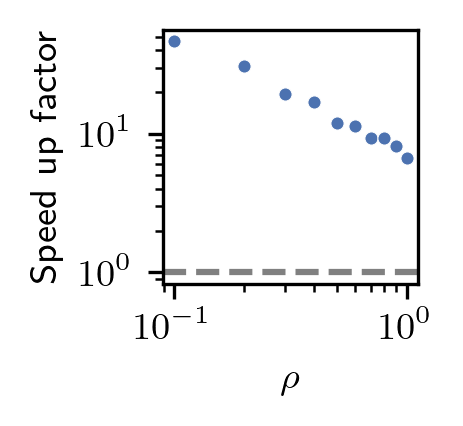

In [530]:
# %%capture

# Separate the 'FE' and 'full' data
fe_df = merged_df[merged_df['mode'] == 'FE'].set_index('rho')
full_df = merged_df[merged_df['mode'] == 'full'].set_index('rho')

# Calculate the speed up, which is the time for 'full' divided by the time for 'FE'
speed_up_df = (full_df['average_time'] / fe_df['average_time']).reset_index(name='speed_up')

plt.figure(figsize=(fig_width, fig_height), dpi=fig_dpi)
ax = sns.scatterplot(data=speed_up_df, x='rho', y='speed_up', s=10, color = palette[0])
plt.axhline(y=1,linestyle='--',color="grey")

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(r'$\rho$')
ax.set_ylabel('Speed up factor')

if yticks != 'default':
    ax.set_yticks(yticks,yticks,minor=False)
    ax.set_yticks(np.arange(1,7),['' for tick in np.arange(1,7)],minor=True)

plt.savefig(fig_directory/f"{sim_type}_speed_up.pdf", bbox_inches="tight", dpi = fig_dpi)


In [531]:
%%capture

# Change labels to desired labels
labels = [legend_info['legend_labels'][label] for label in labels]
# Create a new figure just for the legend
legend_fig, legend_ax = plt.subplots(figsize=(3, .5))  # Create a new subplot
# Add the legend to the subplot
legend_ax.legend(handles, labels, loc='center', ncol = len(labels))
legend_ax.axis('off')  # Turn off the axis

# Draw the legend figure canvas before saving or showing
legend_fig.canvas.draw()
plt.tight_layout()

# Save the legend to a file
plt.savefig(fig_directory/'legend.pdf', bbox_inches='tight')